In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import sunode
import pymc as pm
import arviz as az

In [2]:
data = pd.read_csv('CovidData.csv')

In [4]:
N = 1366417754 #Population at 2019

In [5]:
I = data.loc[:, "Active Cases"]
R = data.loc[:, "New Recoveries"].cumsum()
S = N - I - R
X = data.loc[:, "Dates"]

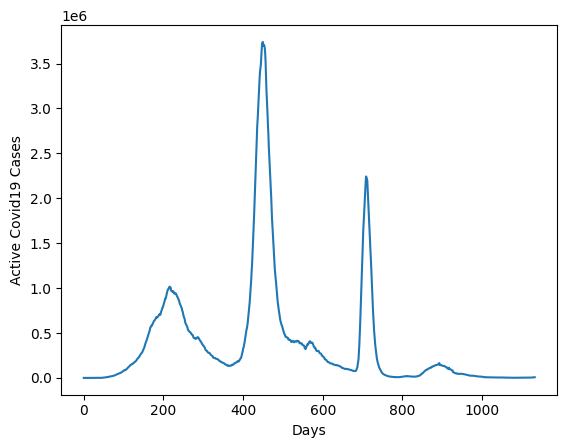

In [6]:
plt.plot(np.linspace(0, len(I), len(I)), I)
plt.xlabel("Days")
plt.ylabel("Active Covid19 Cases")
plt.show()

In [36]:
S_new = np.array(S[800:]) / N
R_new = np.array(R[800:])
I_new = np.array(I[800:])
S_start = S[799] / N
I_start = I[799]
R_start = R[799]
times = np.linspace(0, len(S_new), len(S_new))

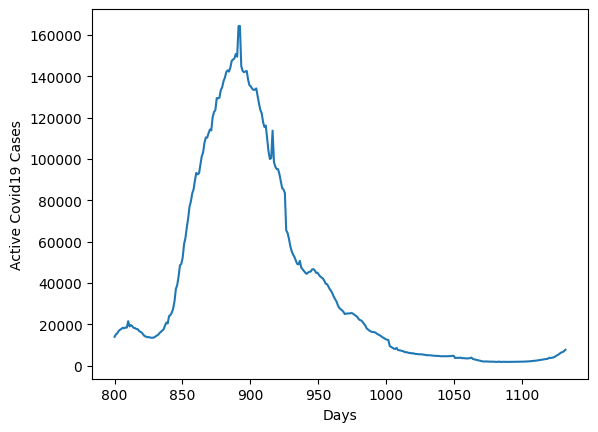

In [37]:
plt.plot(np.linspace(0, len(I_new), len(I_new)) + 800, I_new)
plt.xlabel("Days")
plt.ylabel("Active Covid19 Cases")
plt.show()

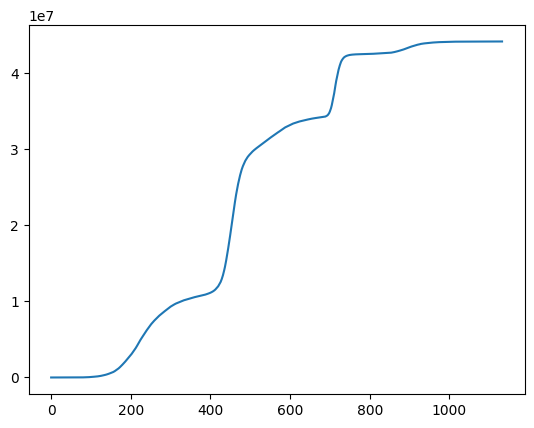

In [12]:
plt.plot(np.linspace(0, len(I), len(I)), R)
plt.show()

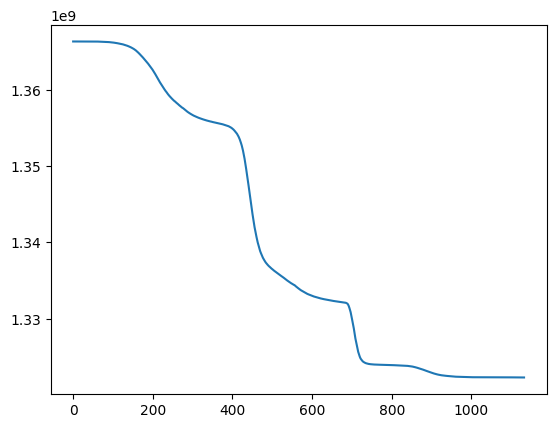

In [13]:
plt.plot(np.linspace(0, len(I), len(I)), S)
plt.show()

In [15]:
import numpy as np
import sunode
import sunode.wrappers.as_pytensor
import pymc as pm
import pytensor.tensor as pt

from pytensor.printing import Print

In [16]:
def sir_sunode(t, y, p):
    return {
            'S': -p.beta * y.S * y.I / p.N,
            'I': p.beta * y.S * y.I - p.gamma * y.I,
            #'R': p.gamma * y.I
    }

In [17]:
import pytensor.tensor as pt
from pytensor.compile.ops import as_op
import sunode
import sunode.wrappers.as_pytensor

In [18]:
lib = sunode._cvodes.lib
with pm.Model() as model:
    beta = pm.Uniform("beta", 2, 3)
    gamma = pm.Uniform("gamma", 2, 3)

    y_hat, _, problem, solver, _, _ = sunode.wrappers.as_pytensor.solve_ivp(
        y0={
            'S': (S_start, ()),
            'I': (I_start, ()),
            #'R': (R_start, ()),
        },
        params={
	    # Each parameter of the ode. sunode will only compute derivatives
	    # with respect to PyTensor variables. The shape needs to be specified
	    # as well. It it infered automatically for numpy variables.
	    # This dict can be nested.
            'beta': (beta, ()),
            'gamma': (gamma, ()),
            'N': (N, ()),
        },
	# A functions that computes the right-hand-side of the ode using
	# sympy variables.
        rhs=sir_sunode,
	# The time points where we want to access the solution
        tvals=times,
        t0=times[0],
    )
    lib.CVodeSStolerances(solver._ode, 1e-6, 1e-6)
    y_new = y_hat["I"]
    y_new = pm.math.clip(y_new, 1, 1366417754)
    #y_print = Print("Y_hat = ")(y_new)
    y_print = y_new
    pm.Poisson('I', mu = y_print, observed = I_new, shape = (len(I_new)))

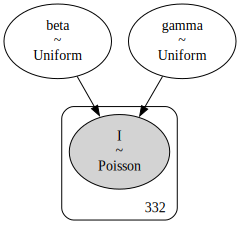

In [20]:
pm.model_to_graphviz(model=model)

In [24]:
with model:
    trace = pm.sample(draws = 2000, chains=4, progressbar=True, random_seed = 0, target_accept = 0.9, cores = 4)

az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta,2.773,0.0,2.772,2.773,0.0,0.0,1829.0,1780.0,1.0
gamma,2.652,0.0,2.652,2.653,0.0,0.0,1829.0,1797.0,1.0


In [71]:
trace.to_netcdf("trace.nc")

'trace2.nc'

array([<Axes: title={'center': 'beta'}>,
       <Axes: title={'center': 'gamma'}>], dtype=object)

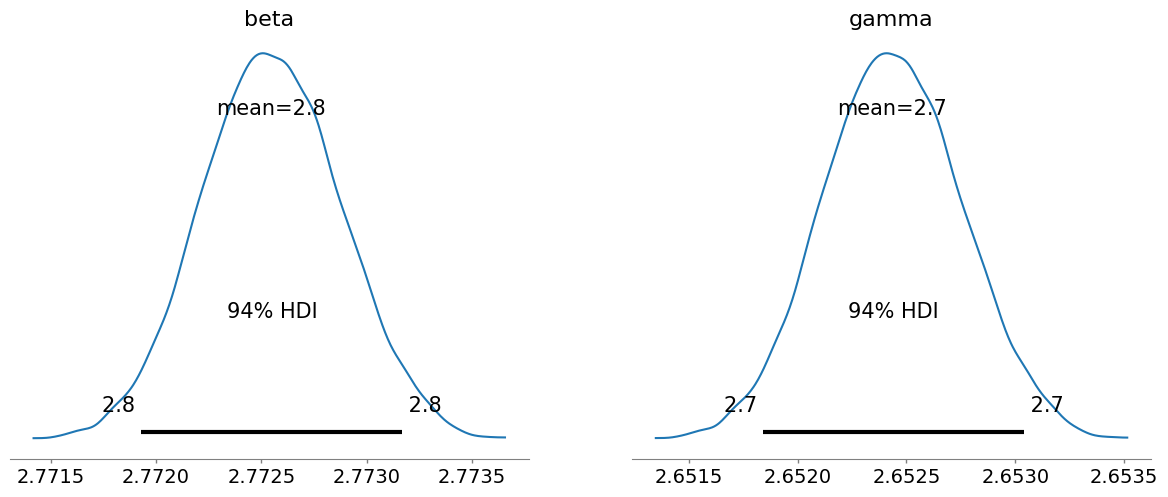

In [22]:
az.plot_posterior(trace, round_to=2)

array([[<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'gamma'}>,
        <Axes: title={'center': 'gamma'}>]], dtype=object)

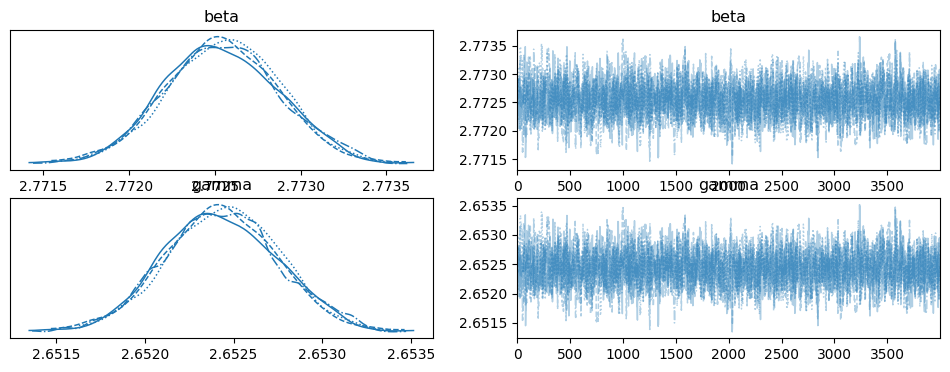

In [23]:
az.plot_trace(trace)

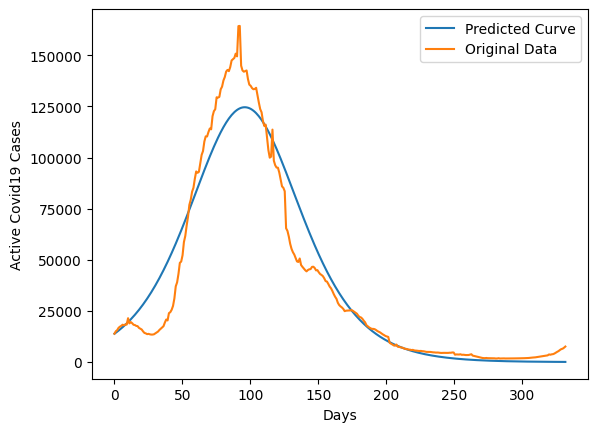

In [30]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Total population, N.
#N = 1000
# Initial number of infected and recovered individuals, I0 and R0.
#I0, R0 = 1, 0
# Everyone else, S0, is susceptible to infection initially.
#S0 = N - I0 - R0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, gamma = 2.773, 2.652
# A grid of time points (in days)
#t = np.linspace(0, 150, 150)

# The SIR model differential equations.
def deriv(y, t, N_new, beta, gamma):
    S, I = y
    dSdt = -beta * S * I / N_new
    dIdt = (beta * S * I) - (gamma * I)
    return dSdt, dIdt

# Initial conditions vector
y0 = S_start, I_start
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, times, args=(N, beta, gamma))
I_boi = ret[:, 1]

plt.plot(times, I_boi, label = "Predict")
plt.plot(times, I_new, label = "Data")
plt.xlabel("Days")
plt.ylabel("Active Covid19 Cases")
plt.legend(["Predicted Curve", "Original Data"])

In [21]:
trace = az.from_netcdf("trace.nc")